In [2]:
import os
import sys
import time
import gc

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
from destruction_utilities import *

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
DEBUG = True
CITY = 'aleppo'
DATA_DIR = "../../data"
PRE_IMAGE_INDEX=[0]
WINDOW = True
WINDOW_SIZE = (20,20)
DATASET = 'all'
BALANCE=False
TILE_SIZE = (128,128)

In [25]:
if WINDOW:
    window = center_window(f'{DATA_DIR}/{CITY}/others/{CITY}_samples.tif', (WINDOW_SIZE[0]*1, WINDOW_SIZE[1]*1))
    samples = read_raster(f'{DATA_DIR}/{CITY}/others/{CITY}_samples.tif', window=window)
else:
    samples = read_raster(f'{DATA_DIR}/{CITY}/others/{CITY}_samples.tif')
images  = search_data(pattern(city=CITY, type='image'), directory=DATA_DIR)
labels  = search_data(pattern(city=CITY, type='label'), directory=DATA_DIR)

In [26]:
if DEBUG:
    print(samples.shape)

(20, 20, 1)


In [27]:
if DATASET=='train' or DATASET=='all':
    delete_zarr_if_exists(CITY, 'labels_siamese_train', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_train_tt', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_train_t0', path=DATA_DIR)

if DATASET=='validate' or DATASET=='all':
    delete_zarr_if_exists(CITY, 'labels_siamese_valid', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_valid_tt', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_valid_t0', path=DATA_DIR)

if DATASET=='test' or DATASET=='all':
    delete_zarr_if_exists(CITY, 'labels_siamese_test', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_test_tt', path=DATA_DIR)
    delete_zarr_if_exists(CITY, 'images_siamese_test_t0', path=DATA_DIR)

In [28]:
image_dates = sorted([el.split("image_")[1].split('.tif')[0] for el in images])
label_dates = sorted([el.split("label_")[1].split('.tif')[0] for el in labels])

for label in label_dates:
    if label.replace("-", "_") not in image_dates:
        latest_available_image = sorted([im for im in image_dates if time.strptime(im, "%Y_%m_%d")  < time.strptime(label, "%Y-%m-%d")])
        latest_available_image = latest_available_image[-1]
        if DEBUG:
            print(label, latest_available_image)
        images.append(images[0].split("image_")[0]+"image_"+latest_available_image+".tif")
images = sorted(images)

2014-05-23 2013_09_23
2015-04-26 2014_07_14
2015-05-01 2014_07_14


In [29]:
if DEBUG:
    for image in images:
        print(image)

../../data/aleppo/images/image_2011_01_01.tif
../../data/aleppo/images/image_2013_05_26.tif
../../data/aleppo/images/image_2013_09_23.tif
../../data/aleppo/images/image_2013_09_23.tif
../../data/aleppo/images/image_2014_07_14.tif
../../data/aleppo/images/image_2014_07_14.tif
../../data/aleppo/images/image_2014_07_14.tif
../../data/aleppo/images/image_2016_03_29.tif
../../data/aleppo/images/image_2016_09_18.tif


In [30]:
for j, pre_image_index in enumerate(PRE_IMAGE_INDEX):
    print(f'------ Using pre image #{j+1}..')

    if WINDOW:
        window = center_window(images[pre_image_index], (WINDOW_SIZE[0]*TILE_SIZE[0], WINDOW_SIZE[1]*TILE_SIZE[1]))
        pre_image = read_raster(images[pre_image_index], window=window)
    else:
        pre_image = read_raster(images[pre_image_index])
    
    pre_image = tile_sequences(np.array([pre_image]), TILE_SIZE)

    for i in range(len(images)):
        if i not in PRE_IMAGE_INDEX:
            if WINDOW:
                window = center_window(labels[i], (WINDOW_SIZE[0]*1, WINDOW_SIZE[1]*1))
                label = np.array(read_raster(labels[i], window=window))
            else:
                label = np.array(read_raster(labels[i]))
            label = label.flatten()
            exclude = np.where(label==-1.0)
            label = np.delete(label, exclude)
            samples_valid = np.delete(samples.flatten(), exclude)
            _, label_train, label_test, label_valid = sample_split(label, samples_valid )

            if DATASET=='train' or DATASET=='all':
                save_zarr(np.equal(label_train, 3), CITY, 'labels_siamese_train', path=DATA_DIR)
            if DATASET=='validate' or DATASET=='all':
                save_zarr(np.equal(label_valid, 3), CITY, 'labels_siamese_valid', path=DATA_DIR)
            if DATASET=='test' or DATASET=='all':
                save_zarr(np.equal(label_test, 3), CITY, 'labels_siamese_test', path=DATA_DIR)


            
            if WINDOW:
                window = center_window(images[i], (WINDOW_SIZE[0]*TILE_SIZE[0], WINDOW_SIZE[1]*TILE_SIZE[1]))
                image = np.array(read_raster(images[i], window=window))
            else:
                image = np.array(read_raster(images[i]))
            image = tile_sequences(np.array([image]), TILE_SIZE)
            image = np.delete(image, exclude, 0)
            _, image_train, image_test, image_valid = sample_split(image, samples_valid)
            if DATASET=='train' or DATASET=='all':
                save_zarr(flatten_image(image_train), CITY, 'images_siamese_train_tt', path=DATA_DIR)
            if DATASET=='validate' or DATASET=='all':
                save_zarr(flatten_image(image_valid), CITY, 'images_siamese_valid_tt', path=DATA_DIR)
            if DATASET=='test' or DATASET=='all':
                save_zarr(flatten_image(image_test), CITY, 'images_siamese_test_tt', path=DATA_DIR)
 
            pre_image_v = np.delete(pre_image, exclude, 0)
            _, pre_image_train, pre_image_test, pre_image_valid = sample_split(pre_image_v, samples_valid)
            if DATASET=='train' or DATASET=='all':
                save_zarr(flatten_image(pre_image_train), CITY, 'images_siamese_train_t0', path=DATA_DIR)
            if DATASET=='validate' or DATASET=='all':
                save_zarr(flatten_image(pre_image_valid), CITY, 'images_siamese_valid_t0', path=DATA_DIR)
            if DATASET=='test' or DATASET=='all':
                save_zarr(flatten_image(pre_image_test), CITY, 'images_siamese_test_t0', path=DATA_DIR)
            print(f'--------- Image {i+1 - len(PRE_IMAGE_INDEX)} of {len(images) - len(PRE_IMAGE_INDEX)} done..')

if DATASET=='train' or DATASET=='all':
    # Generate a balanced (upsampled) dataset and shuffle it..
    delete_zarr_if_exists(CITY, 'labels_siamese_train_balanced')
    delete_zarr_if_exists(CITY, 'images_siamese_train_t0_balanced')
    delete_zarr_if_exists(CITY, 'images_siamese_train_tt_balanced')
    if BALANCE:
        print('--- Generate a balanced (upsampled) dataset..')
        balance_snn(CITY)
    print('--- Shuffle dataset..')
    shuffle_snn(CITY, TILE_SIZE, (100,750))


print('--- Process complete.. \n')
        
    

------ Using pre image #1..
--------- Image 1 of 8 done..
--------- Image 2 of 8 done..
--------- Image 3 of 8 done..
--------- Image 4 of 8 done..
--------- Image 5 of 8 done..
--------- Image 6 of 8 done..
--------- Image 7 of 8 done..
--------- Image 8 of 8 done..
--- Shuffle dataset..
------ Reordering array in batches of 100. Total 72 sets..
--------- Finished 50 sets
------ Shuffling array in batches of 750. Total 9 sets..
(0, 750)
(750, 1500)
(1500, 2250)
(2250, 3000)
(3000, 3750)
(3750, 4500)
(4500, 5250)
(5250, 6000)
(6000, 7240)
--- Process complete.. 



In [31]:
t = read_zarr(CITY, "images_siamese_valid_tt", path=DATA_DIR)

Reading image: ../../data/aleppo/others/aleppo_images_siamese_valid_tt.zarr


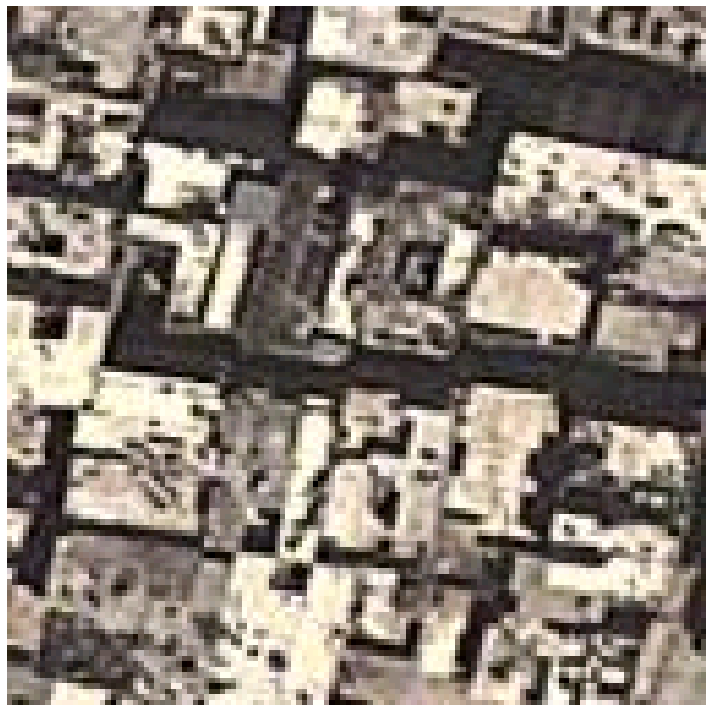

In [34]:
display(t[0].astype('int'))